<a href="https://colab.research.google.com/github/hagalaz-star/PROJECT/blob/main/PROJECT05(%EB%8B%A4%EB%A5%B8%EC%A3%BC%EC%A0%9C)_AI_06_%EC%B5%9C%EC%9B%90%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN 코드 구현 에러


In [2]:
pip install --upgrade pandas

     |████████████████████████████████| 11.3 MB 2.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [8]:
image_dir = "/content/drive/MyDrive/data_set/Images" # 원본 이미지 파일 경로
train_image_dir = "./resized_train/images" # 크기가 조정된 이미지가 담길 경로 (학습)
val_image_dir = "./resized_val/images" # 크기가 조정된 이미지가 담길 경로 (평가)
test_image_dir = "./resized_test/images" # 크기가 조정된 이미지가 담길 경로 (테스트)
size = [256, 256] # 조정될 이미지 크기

In [14]:
def resize_image(image, size):
    # 이미지를 특정 크기로 조정
    return image.resize(size, Image.ANTIALIAS)

# image_dir 내부에 있는 모든 이미지의 크기를 바꾸어 결과 폴더로 옮기기
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # 이미지와 캡션 모두 파일 이름별로 정렬해서 매칭
num_images = len(images)
num_train_images = 6000 # 6000개는 학습용 데이터로 이용
num_val_images = 1000 # 1000개는 평가용 데이터로 이용

for i, image in enumerate(images):
    if (i + 1) <= num_train_images:
        output_dir = train_image_dir
    elif (i + 1) <= num_train_images + num_val_images:
        output_dir = val_image_dir
    else:
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
    if (i + 1) % 500 == 0:
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

[500/8091] Resized the images and saved into './resized_train/images'
[1000/8091] Resized the images and saved into './resized_train/images'
[1500/8091] Resized the images and saved into './resized_train/images'
[2000/8091] Resized the images and saved into './resized_train/images'
[2500/8091] Resized the images and saved into './resized_train/images'
[3000/8091] Resized the images and saved into './resized_train/images'
[3500/8091] Resized the images and saved into './resized_train/images'
[4000/8091] Resized the images and saved into './resized_train/images'
[4500/8091] Resized the images and saved into './resized_train/images'
[5000/8091] Resized the images and saved into './resized_train/images'
[5500/8091] Resized the images and saved into './resized_train/images'
[6000/8091] Resized the images and saved into './resized_train/images'
[6500/8091] Resized the images and saved into './resized_val/images'
[7000/8091] Resized the images and saved into './resized_val/images'
[7500/8091]

이미지 크기: (375, 500)


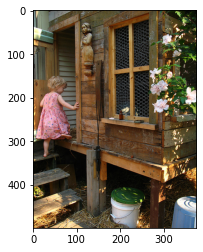

In [16]:
image = Image.open('/content/drive/MyDrive/data_set/Images/1000268201_693b08cb0e.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

In [17]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.jpg"))
        # 데이터의 개수가 적기 때문에 테스트 데이터를 학습 시기에 사용
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.jpg")))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반
        img_B = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반

        # 데이터 증진(data augmentation)을 위한 좌우 반전(horizontal flip)
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [23]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("images", transforms_=transforms_)
val_dataset = ImageDataset("images", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True,num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


ValueError: ignored